In [29]:
import os
import regex
import glob
import multiprocessing as mp
import importlib
import pprint

from typing import Tuple, Callable, Any, NoReturn, List, Dict, Optional

from functools import partial, reduce

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

from pdf2image import convert_from_path, convert_from_bytes
import matplotlib.pyplot as plt
import cv2 as cv
import pytesseract

In [5]:
import timing
importlib.reload(timing)
import timing

In [19]:
# Instantiate a multiprocess pool.
pool = mp.Pool()

In [50]:
@timing.time_log()
def images_to_strings(x):
    """
    """
    
    return {
        nombre: pool.map(pytesseract.image_to_string, archivo) for nombre, archivo in x.items()
    }
##

@timing.time_log()
def tab_by_regex(x: str) -> str:
    """
    """
    
    newline = lambda x: f"{x}\n"
    ntab    = lambda n, txt: n*"\t" + txt
    
    _x_lines: List[str] = x.split('\n')
    _my_str:  str       = ''
        
    for line in _x_lines:
        # Match lines starting with Caps, separated by spaces or points : 
        for i in regex.finditer(r"^([A-Z\s]|[A-Z]\.?)+?(?=(\..+))", line): 
            _my_str += newline(i.string)
            _my_str += newline(ntab(1, i.group()))
            # Match numbers, which could be either integers or floats : 
            for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
                _my_str += newline(ntab(2, j.group()))
            # Match strings found between numbers :
            for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
                _my_str += newline(ntab(3, k.group()))
    
    return _my_str
##

@timing.time_log()
def dict_from_regex(x: str) -> str:
    """
    """
    
    _x_lines: List[str] = x.split('\n')
    
    _dict2 = {}
    for line in _x_lines:
        for i in regex.finditer(r"^([A-Z\s]|[A-Z]\.?)+?(?=(\..+))", line): 
            i.group()
            _valores = []
            _unidades = []
            for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
                _valores.append(j.group())
            for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
                _unidades.append(k.group())
            if len(_valores) < 4 and len(_unidades) < 4:
                _dict2.update({
                    i.group(): {
                        "values": _valores,
                        "units": _unidades
                    }
                })
    
    return _dict2
##

@timing.time_log()
def save_results(x: Dict[str, List[str]]):
    """
        
    """
    
    try:
        if 'segmented' not in os.listdir('.'):
            os.mkdir('segmented')
        
        _camino_resultados = os.path.abspath('segmented')
        _archivos =  list(x.keys())
    
        for i, archivo in enumerate(_archivos):
            for j, page in enumerate(x[archivo]):
                with open(os.path.join(_camino_resultados, f"{_archivos[i].replace('.pdf', '')}.{j+1}.txt"), 'w') as f:
                    f.write(tab_by_regex(page))
    
        return True
    except:
        return False
##                                    

@timing.time_log()
def extract_date(x: Dict[str, List[str]], exclude_date: Optional[str] = None):
    dates = {}
    for nombre, lista in x.items():
        _tmp_list = []
        for string in lista:
            _tmp_list += list(set(
                regex.findall(r"(\d{2}\D[A-Z]{3}\D\d{4}|\d{2}\D\d{2}\D\d{4})", string)
            ))
        dates.update({
            nombre: list(set(_tmp_list))
        })

    if exclude_date is not None:
        for nombre, lista in dates.items():
            dates[nombre] = lfilter(lambda x: x if x != exclude_date else False, lista)
    
    return dates
##

In [51]:
lol = dict_from_regex(strings[archivos[1]][1])
lol

{'GLUCOSA': {'values': ['68', '70', '100'], 'units': [' mg/dL', ' -']},
 'CREATININA': {'values': ['0.76', '0.61', '1.24'], 'units': [' mg/dL', ' -']},
 'ACIDO URICO': {'values': ['4.9', '4.80', '8.70'], 'units': [' mg/dL', ' -']},
 'HEMOGLOBINA GLICOSILADA': {'values': ['6.7', '4.50', '6.30'],
  'units': [' %', ' -']}}

In [33]:
newline = lambda x: f"{x}\n"
ntab = lambda n, txt: n*"\t" + txt

In [7]:
path = os.path.abspath('analisis_clinicos/')
path

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos'

In [8]:
path_textos = os.path.abspath('textos')
path_textos

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/textos'

In [9]:
caminos_textos = glob.glob(f"{path_textos}/*.txt")
caminos_textos.sort()
#caminos_textos

In [10]:
caminos = glob.glob(f"{path}/*.pdf")
#caminos

In [11]:
archivos = [ os.path.split(camino)[1] for camino in caminos]
archivos

['gustavo_maganna_2018-05-13.pdf',
 'gustavo_maganna_2018-05-06.pdf',
 'gustavo_maganna_2019-11-13.pdf',
 'Wed Nov 13 18:05:58 CST 2019.pdf',
 'InformeResultados1-110600.pdf',
 'gustavo_maganna_2018-01-19.pdf']

In [12]:
nombres = [ archivo.replace('.pdf', '') for archivo in archivos ]
nombres

['gustavo_maganna_2018-05-13',
 'gustavo_maganna_2018-05-06',
 'gustavo_maganna_2019-11-13',
 'Wed Nov 13 18:05:58 CST 2019',
 'InformeResultados1-110600',
 'gustavo_maganna_2018-01-19']

In [13]:
ahora_si = { 
    archivo: glob.glob(os.path.join(path_textos ,f"{nombre}.?.txt")) 
    for archivo, nombre in zip(archivos, nombres)
}

In [14]:
[ ahora_si[key].sort() for key in ahora_si.keys() ]
#ahora_si

[None, None, None, None, None, None]

In [15]:
Pats = True

if Pats:
    strings = {}
    for key in ahora_si.keys():
        _strings = []
        for _file in ahora_si[key]:
            with open(_file, 'r') as f:
              _strings.append(f.read())
        strings.update({
            key: _strings
        })

In [16]:
Gus = True

if Gus:
    strings2 = {}
    for key in ahora_si.keys():
        _strings = []
        for _file in ahora_si[key]:
            with open(_file, 'r') as f:
              _strings.append(f.read())
        strings2.update({
            key: _strings
        })

In [34]:
# Obtain text from the PDFs, directly (this takes about a minute) : 
from_scratch = False

if from_scratch:
    imagenes = pool.map(convert_from_path, caminos)
    archivos_en_imagenes = {
        archivo: imagen for archivo, imagen in zip(archivos, imagenes)
    }
    strings = images_to_strings(archivos_en_imagenes)

In [13]:
# Send all of these files to texts/
save = False

if save:
    for nombre, hojas in strings.items():
        for i, hoja in enumerate(hojas):
            _file_name = os.path.join(path_textos, f"{nombre.replace('.pdf', '')}.{i}.txt")
            with open(_file_name, "w") as f:
                f.write(hoja)

In [22]:
for lista in strings.values():
    for string in lista:
        print(regex.findall(r"\d{2}/\d{2}/\d{4}", string))

['06/08/1996', '13/05/2018', '13/05/2018']
['06/08/1996', '13/05/2018', '13/05/2018']
['06/08/1996', '13/05/2018', '13/05/2018']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']


In [23]:
dates = {}
for nombre, lista in strings.items():
    _tmp_list = []
    for string in lista:
        _tmp_val = set(regex.findall(r"(\d{2}\D[A-Z]{3}\D\d{4}|\d{2}\D\d{2}\D\d{4})", string))
        if len(_tmp_list) == 0:
            _tmp_list.append(_tmp_val)
        else:
            if _tmp_val not in _tmp_list:
                _tmp_list.append(_tmp_val)
    dates.update({
        nombre: _tmp_list
    })
pprint.pprint(dates)

{'InformeResultados1-110600.pdf': [{'15-NOV-2019', '06/08/1996'}],
 'Wed Nov 13 18:05:58 CST 2019.pdf': [{'06/08/1996', '13-NOV-2019'}],
 'gustavo_maganna_2018-01-19.pdf': [{'19-ENE-2018', '06/08/1996'}],
 'gustavo_maganna_2018-05-06.pdf': [{'06/08/1996'}],
 'gustavo_maganna_2018-05-13.pdf': [{'13/05/2018', '06/08/1996'}],
 'gustavo_maganna_2019-11-13.pdf': [{'06/08/1996', '13-NOV-2019'}]}


In [26]:
dates = {}
for nombre, lista in strings.items():
    _tmp_list = []
    for string in lista:
        _tmp_list += list(set(
            regex.findall(r"(\d{2}\D[A-Z]{3}\D\d{4}|\d{2}\D\d{2}\D\d{4})", string)
        ))
    dates.update({
        nombre: list(set(_tmp_list))
    })

for nombre, lista in dates.items():
    dates[nombre] = lfilter(lambda x: x if x != someval else False, lista)
    

pprint.pprint(dates)

{'InformeResultados1-110600.pdf': ['15-NOV-2019', '06/08/1996'],
 'Wed Nov 13 18:05:58 CST 2019.pdf': ['06/08/1996', '13-NOV-2019'],
 'gustavo_maganna_2018-01-19.pdf': ['19-ENE-2018', '06/08/1996'],
 'gustavo_maganna_2018-05-06.pdf': ['06/08/1996'],
 'gustavo_maganna_2018-05-13.pdf': ['13/05/2018', '06/08/1996'],
 'gustavo_maganna_2019-11-13.pdf': ['06/08/1996', '13-NOV-2019']}


In [37]:
print(tab_by_regex(strings[archivos[1]][0]))

ARANDA DE LA PARRA DIR. (477) 719-71-02 CONM. 719-71-00 EXT. 143 Y 145 TEL/FAX: 713-33-03
	ARANDA DE LA PARRA DIR
		477
		719
		71
		02
		719
		71
		00
		143
		145
		713
		33
		03
			 CONM.
			 EXT.
			 Y
			 TEL/FAX:
HEMOGLOBINA........0ccccceeeeeeeeeeeee 16.9 g/dL t 14.10 - 16.30
	HEMOGLOBINA
		0
		16.9
		14.10
		16.30
			ccccceeeeeeeeeeeee
			 g/dL
			 -
HEMATOCRITO. 48.0 % tT 41-47
	HEMATOCRITO
		48.0
		41
		47
			 %
V.C.M.... 86.2 fL 84 - 94
	V
		86.2
		84
		94
			 fL
			 -
LEUCOCITOS.......cccccecceecneeeeeeeeee 5.9 Mil/microL 5.30 - 9.50
	LEUCOCITOS
		5.9
		5.30
		9.50
			 Mil/microL
			 -
PLAQUETAS.......0ccccccceeee tsetse 163 Mil/microL 150 - 450
	PLAQUETAS
		0
		163
		150
		450
			ccccccceeee
			 Mil/microL
			 -



In [3]:
s = set([1, 2, 3, 3])

In [86]:
s.discard(1)
len(s)

2

In [85]:
len(s.difference(s))

0

In [83]:
dif.

set()

In [52]:
nombres

['gustavo_maganna_2018-05-13',
 'gustavo_maganna_2018-05-06',
 'gustavo_maganna_2019-11-13',
 'Wed Nov 13 18:05:58 CST 2019',
 'InformeResultados1-110600',
 'gustavo_maganna_2018-01-19']

In [15]:
_file = archivos[1]
print(_file)
print(len(strings[_file]))
print(strings[_file][2])

gustavo_maganna_2018-05-06.pdf
5
LABORATORIO DE PATOLOGIA CLINICA

HOSPITAL AVENIDA HIDALGO No 329 C.P. : 37000 LEON, GTO.
ARANDA DE LA PARRA DIR. (477) 719-71-02 CONM. 719-71-00 EXT. 143 Y 145 TEL/FAX: 713-33-03
TODA LA VIDA CONTIGO
Paciente: GUSTAVO MAGANA LOPEZ Edad: 21 ANOS Sexo: MASCULINO — Cuarto — Cama:
Expediente: Folio: 028028 Seccion: EXTERNO
Fecha Nac.:06/08/1996 Fecha ingreso: 6-MAY-2018 09:20 AM_ Fecha—Hora ler Impresion:6-MAY-2018 01:34 PM

Médico:JUAN CARLOS FERRER SERRANO Procedencia: H. ARANDA DE LA

Ultima Impresion: 6-MAY-2018 07:58 PM

 

 

PARRA
. U. de :
Estudio Resultado Medida Intervalo de Referencia
PERFIL DE LIPIDOS
COLESTEROL....sssssssssssssssesssssssseeeeees 118 mg/dL | 140 - 200 v
< 150 Normal
TRIGLICERIDOS ....csscsscssessenseesee 50 mg/dL 300-500 Noe v
>500 Muy Alto
VLDL COLESTEROL.....s-:ssccssssssseeeeeee 10 mg/dL 5-35
< 100 Optimo |
LDL COLESTEROL...sscssssssssessssesenee 72 mg/dL 130. 169 Lenwnte ato v
160 - 189 Alto
>= 190 Muy Alto
INDICE DE RIESGO

In [17]:
foo = strings[_file][2]

# Split by line breaks :
foo_lines = foo.split("\n")

# Select valid lines (i.e. longer than 5 characters) :
foo_lines = [ line for line in foo_lines ] # if len(line) > 1 ]

#regex.compile(r'[A-Z]')
print(foo_lines[10])
print(foo_lines[14])
"""
for line in foo_lines:
    for i in regex.finditer(r"[0a-z]{2,}", line):
        print(foo_lines[14])
        #print(i.string)
        #print('\t', i.group())
"""

'\nfor line in foo_lines:\n    for i in regex.finditer(r"[0a-z]{2,}", line):\n        print(foo_lines[14])\n        #print(i.string)\n        #print(\'\t\', i.group())\n'

In [29]:
#print(foo)

In [27]:
#print(tab_by_regex(strings[archivos[2]][0]))

In [30]:
nombres

['gustavo_maganna_2018-05-13',
 'gustavo_maganna_2018-05-06',
 'gustavo_maganna_2019-11-13',
 'Wed Nov 13 18:05:58 CST 2019',
 'InformeResultados1-110600',
 'gustavo_maganna_2018-01-19']

In [28]:
archivos

['gustavo_maganna_2018-05-13.pdf',
 'gustavo_maganna_2018-05-06.pdf',
 'gustavo_maganna_2019-11-13.pdf',
 'Wed Nov 13 18:05:58 CST 2019.pdf',
 'InformeResultados1-110600.pdf',
 'gustavo_maganna_2018-01-19.pdf']

In [29]:
camino_resultados = os.path.abspath('segmented')
camino_resultados

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/segmented'

In [48]:
save_results(strings)

True

In [38]:
os.mkdir('hue')

In [34]:
for i, archivo in enumerate(archivos):
    for j, page in enumerate(strings[archivo]):
        with open(os.path.join(camino_resultados, f"{nombres[i]}.{j+1}.txt"), 'w') as f:
            f.write(tab_by_regex(page))

In [19]:
newline = lambda x: f"{x}\n"
ntab = lambda n, txt: n*"\t" + txt

In [27]:
_my_str = ''
for line in foo_lines:
    for i in regex.finditer(r"^([A-Z\s]|[A-Z]\.?)+?(?=(\..+))", line): # FIND lines starting with Caps 
        _my_str += newline(i.string)
        _my_str += newline(ntab(1, i.group()))
        for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
            _my_str += newline(ntab(2, j.group()))
        for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
            _my_str += newline(ntab(3, k.group()))

In [28]:
print(_my_str)

ARANDA DE LA PARRA DIR. (477) 719-71-02 CONM. 719-71-00 EXT. 143 Y 145 TEL/FAX: 713-33-03
	ARANDA DE LA PARRA DIR
		477
		719
		71
		02
		719
		71
		00
		143
		145
		713
		33
		03
			 CONM.
			 EXT.
			 Y
			 TEL/FAX:
COLESTEROL....sssssssssssssssesssssssseeeeees 118 mg/dL | 140 - 200 v
	COLESTEROL
		118
		140
		200
			 mg/dL
			 -
TRIGLICERIDOS ....csscsscssessenseesee 50 mg/dL 300-500 Noe v
	TRIGLICERIDOS 
		50
		300
		500
			 mg/dL
			 Noe
VLDL COLESTEROL.....s-:ssccssssssseeeeeee 10 mg/dL 5-35
	VLDL COLESTEROL
		10
		5
		35
			 mg/dL
LDL COLESTEROL...sscssssssssessssesenee 72 mg/dL 130. 169 Lenwnte ato v
	LDL COLESTEROL
		72
		130
		169
			 mg/dL
			 Lenwnte
HDL COLESTEROL.......csssccsssseeeesseee 33 mg/dL IEERMEDIO. cases v
	HDL COLESTEROL
		33
			 mg/dL
ALTO... MENOR A 35,
	ALTO
		35
LIPIDOS TOTALES......:ssssssscsseeesssesseees 337 mg/dL | 450 - 1000
	LIPIDOS TOTALES
		337
		450
		1000
			 mg/dL
			 -
INDICE ATEROGENICO... 3.6 RiEScO INTERMEDIO: 4.5 -8
	INDICE ATEROGENICO
		3.6

In [31]:
"""
for line in foo_lines:
    for i in regex.finditer(r"^([A-Z\s]|[A-Z]\.?)+?(?=(\..+))", line): # FIND lines starting with Caps 
        print(i.string)
        print('\t',i.group())
        for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
            print(2*'\t',j.group())
        for k in regex.finditer(r"(?<=(\d+\.\d+|\d+))\D[^\d]+?(?=\s)", i.string):
            print(3*'\t',k.group())
"""

'\nfor line in foo_lines:\n    for i in regex.finditer(r"^([A-Z\\s]|[A-Z]\\.?)+?(?=(\\..+))", line): # FIND lines starting with Caps \n        print(i.string)\n        print(\'\t\',i.group())\n        for j in regex.finditer(r"(\\d+\\.\\d+|\\d+)", i.string): # find groups of numbers\n            print(2*\'\t\',j.group())\n        for k in regex.finditer(r"(?<=(\\d+\\.\\d+|\\d+))\\D[^\\d]+?(?=\\s)", i.string):\n            print(3*\'\t\',k.group())\n'

In [33]:
# My regexps :

my_may_ge_2 = r"^[A-Z]{2,}"  # Find CAPITAL WORDS longer than 2, at the begining of the line.
my_numbers = r"(\d+\.\d+|\d+)" # Find numbers of any length, with a decimal point or not.
my_from_begining_until_point = r"^.+?(?=(\..+))" # Find any text before the first occurrence of a pint
my_caps_and_whitespace_until_point = r"^[A-Z\s]+?(?=(\..+))"
my_caps_and_whitspace_or_acronym_until_point = r"^([A-Z\s|[A-Z]\.?)+?(?=(\..+))"
my_failed_extract_units = r"(?<=((\d+\.\d+|\d+)+))(.+)"
googled_text_between_brackets = r"(?<=\[).+?(?=\])"
my_extract_units = r"(?<=(\d+\.\d+|\d+))\D+?(?=(\d+\.\d+|\d+))"
my_better_extract_units_between_numbers = r"(?<=(\d+\.\d+|\d+))\D[^\.\d]+?(?=(\d+\.\d+|\d+))"
my_extract_units_between_numbers_and_whitespace = r"(?<=(\d+\.\d+|\d+))\D[^\.\d]+?(?=\s)"

In [34]:
dir(regex)
help(regex.purge)

Help on function purge in module regex.regex:

purge()
    Clear the regular expression cache



In [35]:
for line in foo_lines:
    for i in regex.findall(r"^[A-Z]{2,}", line):
        print(i)

LABORATORIO
HOSPITAL
ARANDA
TODA
PARRA
PERFIL
COLESTEROL
TRIGLICERIDOS
VLDL
LDL
INDICE
HDL
ALTO
LIPIDOS
INDICE
METODOLOGIA
TIPO
NOTA
RIESGO


In [36]:
#dir(i)

In [37]:
#i.expand()

In [129]:
help(regex.compile)

Help on function compile in module regex.regex:

compile(pattern, flags=0, **kwargs)
    Compile a regular expression pattern, returning a pattern object.



In [38]:
#regex.compile()

In [93]:
[
    reduce(lambda x, y: x + y if y.isupper() else x, line, '')
    for line in woo
]

['LABORATORIODEPATOLOGIACLINICA',
 'HOSPITAL',
 '',
 'AVENIDAHIDALGONCPLEONGTO',
 'ARANDADELAPARRADIRCONMEXTYTELFAX',
 '',
 'TODALAVIDACONTIGO',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'PGUSTAVOMAGANALOPEZEANOSSMASCULINOCC',
 'EFSEXTERNO',
 'FNFMAYAMFHIMAYPM',
 'MJUANCARLOSFERRERSERRANOHARANDADELAUIMAYPM',
 'U',
 'ERMIR',
 'BIOMETRIAHEMATICAV',
 'FORMULAROJA',
 'HEMOGLOBINAL',
 'HEMATOCRITOT',
 'L',
 'ERITROCITOST',
 'VCML',
 '',
 '',
 'FORMULABLANCA',
 'LEUCOCITOSML',
 'DIFERENCIALLEUCOCITARIA',
 'LINFOCITOS',
 'MONOCITOS',
 'EOSINOFILOS',
 'BASOFILOS',
 'SEGMENTADOS',
 'BANDAS',
 'VALORESABSOLUTOS',
 'LINFOCITOSML',
 'MONOCITOSML',
 'EOSINOFILOSML',
 'BASOFILOSML',
 'NEUTROFILOSML',
 'PLAQUETASML',
 'METODOLOGIACIANOMETAHEMOGLOBINAIMPEDANCIAYRAYOLASER',
 'TIPODEMUESTRASANGRETOTALCONEDTA',
 '',
 'A',
 '',
 'VQFBMARIAGUADALUPEMUNOZVELAZQUEZ',
 'NOTAEC',
 'RDGAOPCUANL

In [95]:
#dir('')

In [101]:
x = "\n hola \n"

In [103]:
r"{}".format(x)

'\n hola \n'

In [99]:
print(r'\n\nhola')

\n\nhola


In [74]:
with open('watever', 'w') as lol:
    lol.write(strings[archivos[2]][0])

In [75]:
# Cuántas líneas tenemos en total :
caracteres_por_linea = pd.core.series.Series(
    [
     len(line) for line in page.split('\n') 
     for pdf in strings 
     for page in pdf
    ],
    name='caracteres'
)

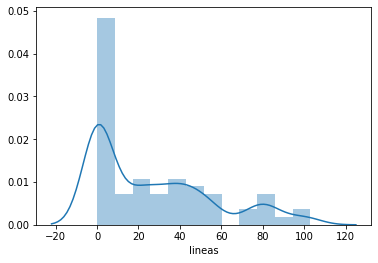

In [76]:
sns.distplot(caracteres)

In [36]:
archivos[0]

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2018-05-13.pdf'

In [34]:
if False:
    for pdf in strings:
        for page in pdf:
            print(page)

In [ ]:
#pool.close()
#pool.terminate()